# Lesson 1.7: Edge Detection
## Biomedical Image Processing - Basic Concepts

### Topics:
- What are edges in images?
- Gradient-based edge detection
- Sobel, Prewitt, and Laplacian operators
- Canny edge detector
- Applications in medical imaging

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. What is an Edge?

An **edge** is a boundary where pixel intensity changes rapidly.

Edges represent:
- Object boundaries
- Texture changes
- Surface discontinuities

In medical imaging, edges help identify:
- Organ boundaries
- Tumor margins
- Vessel walls
- Bone structures

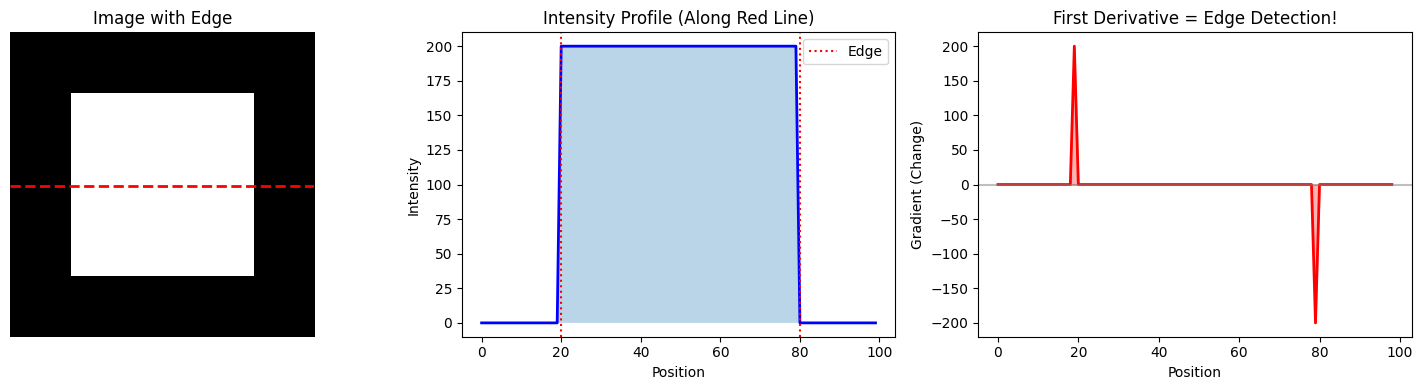

Key Insight: Edges occur where the gradient (derivative) is high!
Positive gradient = dark to bright transition
Negative gradient = bright to dark transition


In [2]:
# Create a simple image with clear edges
simple = np.zeros((100, 100), dtype=np.uint8)
simple[20:80, 20:80] = 200  # White square on black background

# Show intensity profile
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(simple, cmap='gray')
axes[0].axhline(y=50, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Image with Edge')
axes[0].axis('off')

# Intensity profile along the red line
profile = simple[50, :]
axes[1].plot(profile, 'b-', linewidth=2)
axes[1].fill_between(range(100), profile, alpha=0.3)
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Intensity')
axes[1].set_title('Intensity Profile (Along Red Line)')
axes[1].axvline(x=20, color='red', linestyle=':', label='Edge')
axes[1].axvline(x=80, color='red', linestyle=':')
axes[1].legend()

# Derivative (gradient) of profile
gradient = np.diff(profile.astype(float))
axes[2].plot(gradient, 'r-', linewidth=2)
axes[2].fill_between(range(99), gradient, alpha=0.3, color='red')
axes[2].set_xlabel('Position')
axes[2].set_ylabel('Gradient (Change)')
axes[2].set_title('First Derivative = Edge Detection!')
axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

print("Key Insight: Edges occur where the gradient (derivative) is high!")
print("Positive gradient = dark to bright transition")
print("Negative gradient = bright to dark transition")

## 2. Image Gradients

For 2D images, we compute gradients in both x and y directions:

- **Gx**: Horizontal gradient (vertical edges)
- **Gy**: Vertical gradient (horizontal edges)

**Gradient Magnitude**: $G = \sqrt{G_x^2 + G_y^2}$

**Gradient Direction**: $\theta = \arctan(G_y / G_x)$

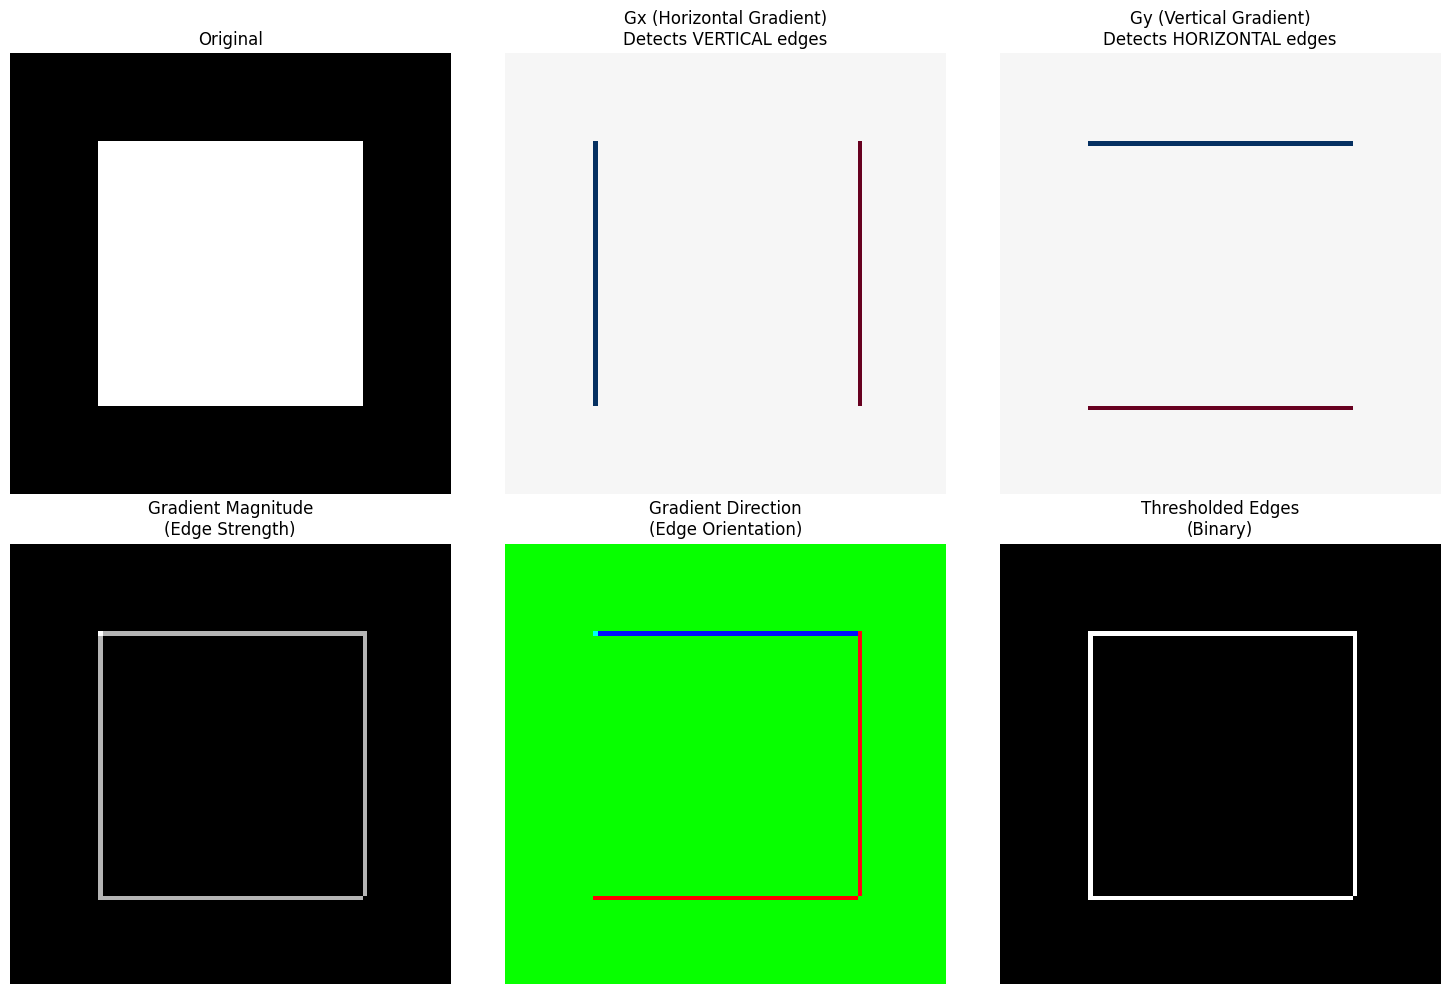

In [3]:
def simple_gradient(img):
    """Compute simple gradient using finite differences."""
    img = img.astype(np.float32)
    
    # Gx: Difference in x direction (horizontal gradient)
    gx = np.zeros_like(img)
    gx[:, 1:] = img[:, 1:] - img[:, :-1]
    
    # Gy: Difference in y direction (vertical gradient)
    gy = np.zeros_like(img)
    gy[1:, :] = img[1:, :] - img[:-1, :]
    
    # Magnitude
    magnitude = np.sqrt(gx**2 + gy**2)
    
    # Direction (in degrees)
    direction = np.arctan2(gy, gx) * 180 / np.pi
    
    return gx, gy, magnitude, direction

# Apply to simple image
gx, gy, mag, direction = simple_gradient(simple)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(simple, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(gx, cmap='RdBu', vmin=-200, vmax=200)
axes[0, 1].set_title('Gx (Horizontal Gradient)\nDetects VERTICAL edges')
axes[0, 1].axis('off')

axes[0, 2].imshow(gy, cmap='RdBu', vmin=-200, vmax=200)
axes[0, 2].set_title('Gy (Vertical Gradient)\nDetects HORIZONTAL edges')
axes[0, 2].axis('off')

axes[1, 0].imshow(mag, cmap='gray')
axes[1, 0].set_title('Gradient Magnitude\n(Edge Strength)')
axes[1, 0].axis('off')

axes[1, 1].imshow(direction, cmap='hsv')
axes[1, 1].set_title('Gradient Direction\n(Edge Orientation)')
axes[1, 1].axis('off')

# Thresholded edges
edges = mag > 50
axes[1, 2].imshow(edges, cmap='gray')
axes[1, 2].set_title('Thresholded Edges\n(Binary)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 3. Sobel Operator

The **Sobel operator** uses 3x3 kernels for smoother gradient estimation:

$$
G_x = \begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix}
\quad
G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ +1 & +2 & +1 \end{bmatrix}
$$

The center row/column has higher weights (2) for smoothing.

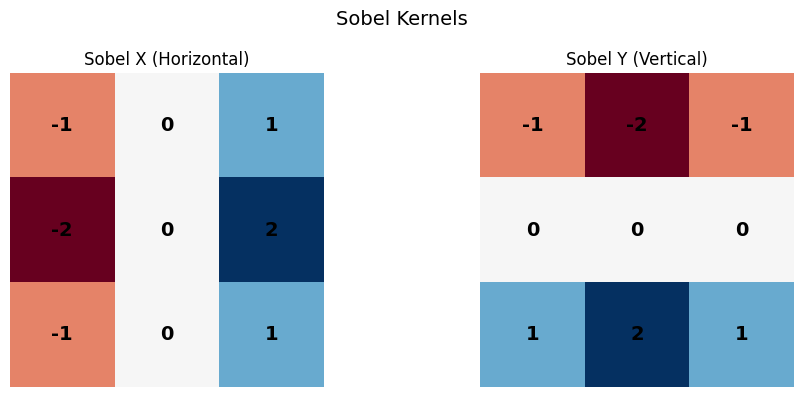

In [4]:
def convolve2d(img, kernel):
    """Apply 2D convolution."""
    h, w = img.shape
    kh, kw = kernel.shape
    pad_h, pad_w = kh // 2, kw // 2
    
    padded = np.pad(img.astype(np.float32), ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    output = np.zeros((h, w), dtype=np.float32)
    
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)
    
    return output

# Sobel kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]], dtype=np.float32)

# Visualize Sobel kernels
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, kernel, title in zip(axes, [sobel_x, sobel_y], ['Sobel X (Horizontal)', 'Sobel Y (Vertical)']):
    ax.imshow(kernel, cmap='RdBu', vmin=-2, vmax=2)
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f'{kernel[i,j]:.0f}', ha='center', va='center', fontsize=14, fontweight='bold')
    ax.set_title(title)
    ax.axis('off')

plt.suptitle('Sobel Kernels', fontsize=14)
plt.tight_layout()
plt.show()

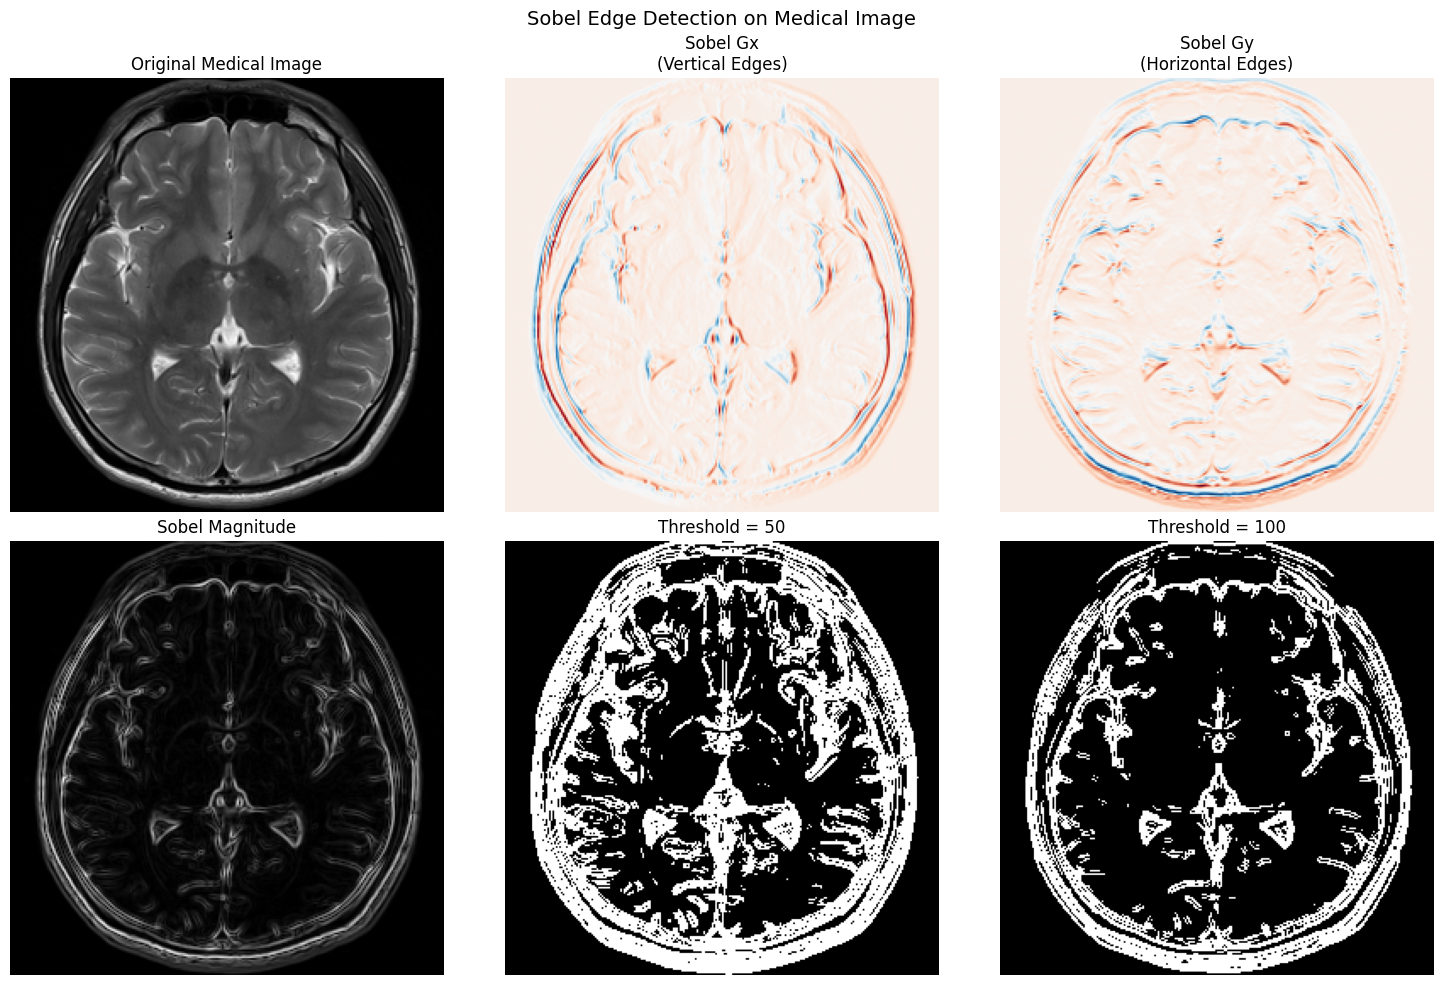

In [5]:
# Load or create medical image
current_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else '.'
img_path = os.path.join(current_dir, 'grayscale_raw.png')

try:
    medical_img = np.array(Image.open(img_path).convert('L').resize((256, 256)))
except:
    # Create synthetic medical image
    np.random.seed(42)
    medical_img = np.ones((256, 256)) * 80
    y, x = np.ogrid[:256, :256]
    # Lungs
    left_lung = ((x - 80)**2/2000 + (y - 128)**2/4000) < 1
    right_lung = ((x - 176)**2/2000 + (y - 128)**2/4000) < 1
    medical_img[left_lung] = 40
    medical_img[right_lung] = 40
    # Heart
    heart = ((x - 128)**2/800 + (y - 140)**2/1000) < 1
    medical_img[heart] = 100
    # Spine
    medical_img[30:226, 122:134] = 120
    # Ribs
    for offset in range(50, 200, 25):
        medical_img[offset:offset+6, 70:186] = 110
    medical_img = medical_img.astype(np.uint8)

# Apply Sobel operator
sobel_gx = convolve2d(medical_img, sobel_x)
sobel_gy = convolve2d(medical_img, sobel_y)
sobel_magnitude = np.sqrt(sobel_gx**2 + sobel_gy**2)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(medical_img, cmap='gray')
axes[0, 0].set_title('Original Medical Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(sobel_gx, cmap='RdBu')
axes[0, 1].set_title('Sobel Gx\n(Vertical Edges)')
axes[0, 1].axis('off')

axes[0, 2].imshow(sobel_gy, cmap='RdBu')
axes[0, 2].set_title('Sobel Gy\n(Horizontal Edges)')
axes[0, 2].axis('off')

axes[1, 0].imshow(sobel_magnitude, cmap='gray')
axes[1, 0].set_title('Sobel Magnitude')
axes[1, 0].axis('off')

# Different thresholds
axes[1, 1].imshow(sobel_magnitude > 50, cmap='gray')
axes[1, 1].set_title('Threshold = 50')
axes[1, 1].axis('off')

axes[1, 2].imshow(sobel_magnitude > 100, cmap='gray')
axes[1, 2].set_title('Threshold = 100')
axes[1, 2].axis('off')

plt.suptitle('Sobel Edge Detection on Medical Image', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Prewitt Operator

Similar to Sobel, but with equal weights:

$$
G_x = \begin{bmatrix} -1 & 0 & +1 \\ -1 & 0 & +1 \\ -1 & 0 & +1 \end{bmatrix}
\quad
G_y = \begin{bmatrix} -1 & -1 & -1 \\ 0 & 0 & 0 \\ +1 & +1 & +1 \end{bmatrix}
$$

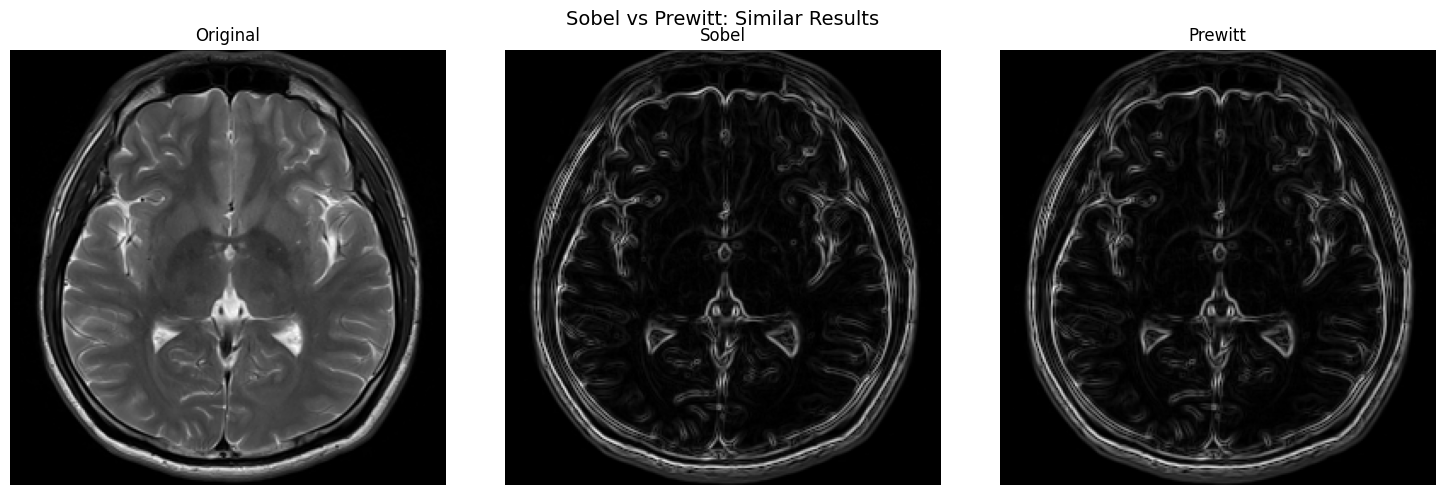

Sobel gives slightly more weight to closer pixels (center row/column).
Prewitt treats all neighbors equally.


In [6]:
# Prewitt kernels
prewitt_x = np.array([[-1, 0, 1],
                      [-1, 0, 1],
                      [-1, 0, 1]], dtype=np.float32)

prewitt_y = np.array([[-1, -1, -1],
                      [0, 0, 0],
                      [1, 1, 1]], dtype=np.float32)

# Apply
prewitt_gx = convolve2d(medical_img, prewitt_x)
prewitt_gy = convolve2d(medical_img, prewitt_y)
prewitt_magnitude = np.sqrt(prewitt_gx**2 + prewitt_gy**2)

# Compare Sobel vs Prewitt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(medical_img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(sobel_magnitude, cmap='gray')
axes[1].set_title('Sobel')
axes[1].axis('off')

axes[2].imshow(prewitt_magnitude, cmap='gray')
axes[2].set_title('Prewitt')
axes[2].axis('off')

plt.suptitle('Sobel vs Prewitt: Similar Results', fontsize=14)
plt.tight_layout()
plt.show()

print("Sobel gives slightly more weight to closer pixels (center row/column).")
print("Prewitt treats all neighbors equally.")

## 5. Laplacian Operator (Second Derivative)

The **Laplacian** detects edges using second derivative:

$$
\nabla^2 f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}
$$

Common kernels:
$$
\begin{bmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{bmatrix}
\quad \text{or} \quad
\begin{bmatrix} 1 & 1 & 1 \\ 1 & -8 & 1 \\ 1 & 1 & 1 \end{bmatrix}
$$

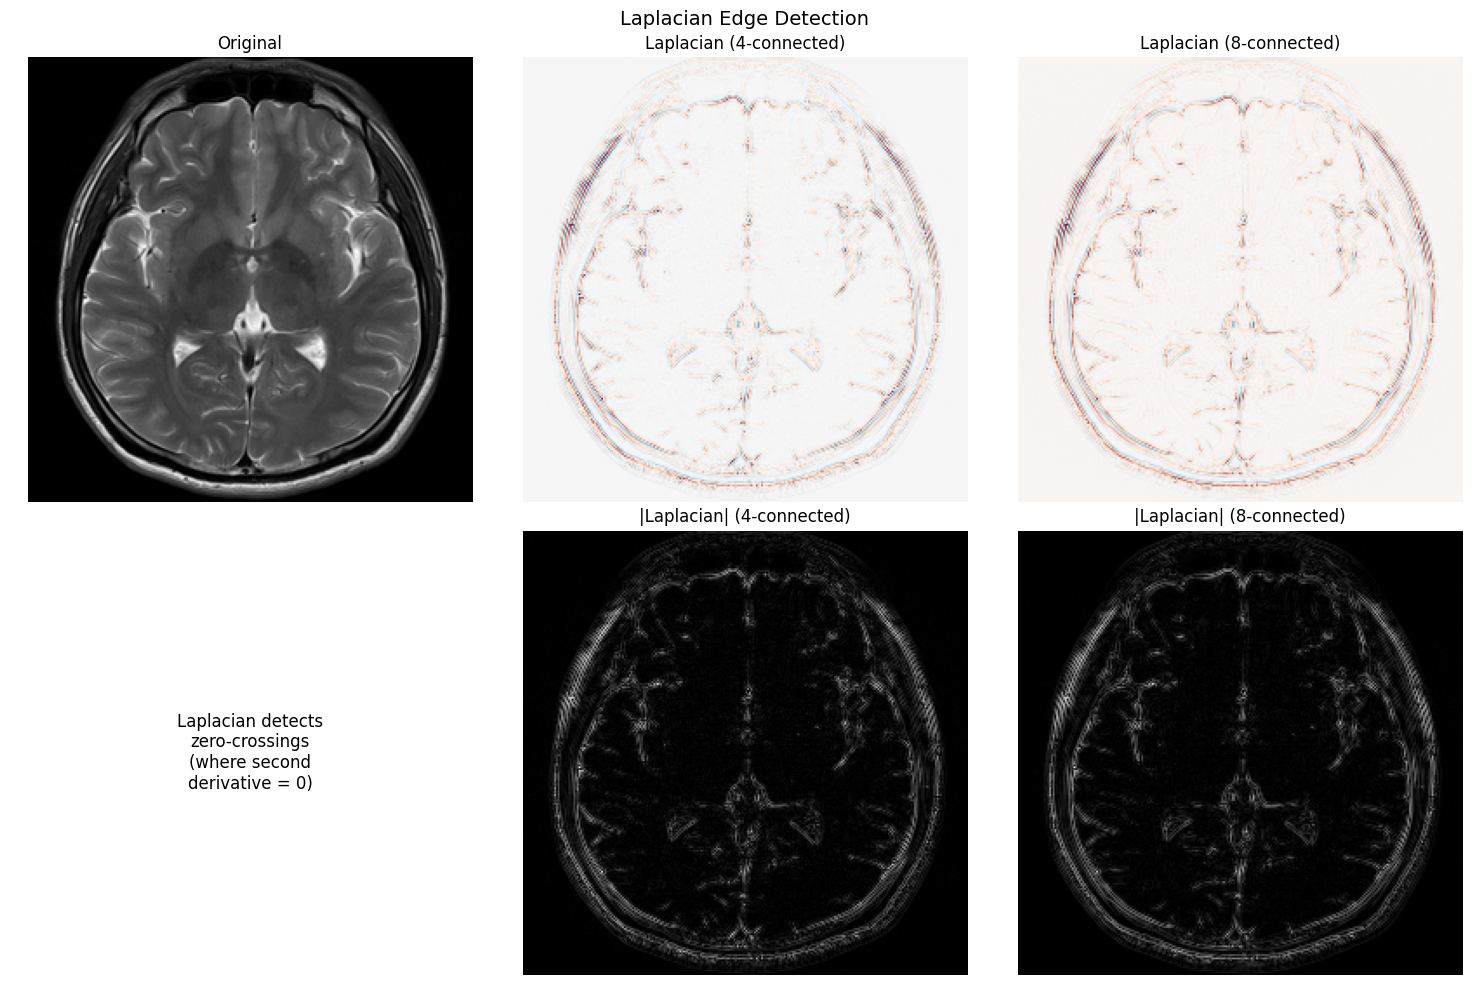

Laplacian is more sensitive to noise than gradient-based methods.
Often used with Gaussian smoothing first (LoG = Laplacian of Gaussian).


In [7]:
# Laplacian kernels
laplacian_4 = np.array([[0, 1, 0],
                        [1, -4, 1],
                        [0, 1, 0]], dtype=np.float32)

laplacian_8 = np.array([[1, 1, 1],
                        [1, -8, 1],
                        [1, 1, 1]], dtype=np.float32)

# Apply
lap_4 = convolve2d(medical_img, laplacian_4)
lap_8 = convolve2d(medical_img, laplacian_8)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(medical_img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(lap_4, cmap='RdBu')
axes[0, 1].set_title('Laplacian (4-connected)')
axes[0, 1].axis('off')

axes[0, 2].imshow(lap_8, cmap='RdBu')
axes[0, 2].set_title('Laplacian (8-connected)')
axes[0, 2].axis('off')

axes[1, 0].axis('off')
axes[1, 0].text(0.5, 0.5, 'Laplacian detects\nzero-crossings\n(where second\nderivative = 0)',
                ha='center', va='center', fontsize=12)

axes[1, 1].imshow(np.abs(lap_4), cmap='gray')
axes[1, 1].set_title('|Laplacian| (4-connected)')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.abs(lap_8), cmap='gray')
axes[1, 2].set_title('|Laplacian| (8-connected)')
axes[1, 2].axis('off')

plt.suptitle('Laplacian Edge Detection', fontsize=14)
plt.tight_layout()
plt.show()

print("Laplacian is more sensitive to noise than gradient-based methods.")
print("Often used with Gaussian smoothing first (LoG = Laplacian of Gaussian).")

## 6. Laplacian of Gaussian (LoG)

To reduce noise sensitivity, we first smooth with Gaussian, then apply Laplacian.

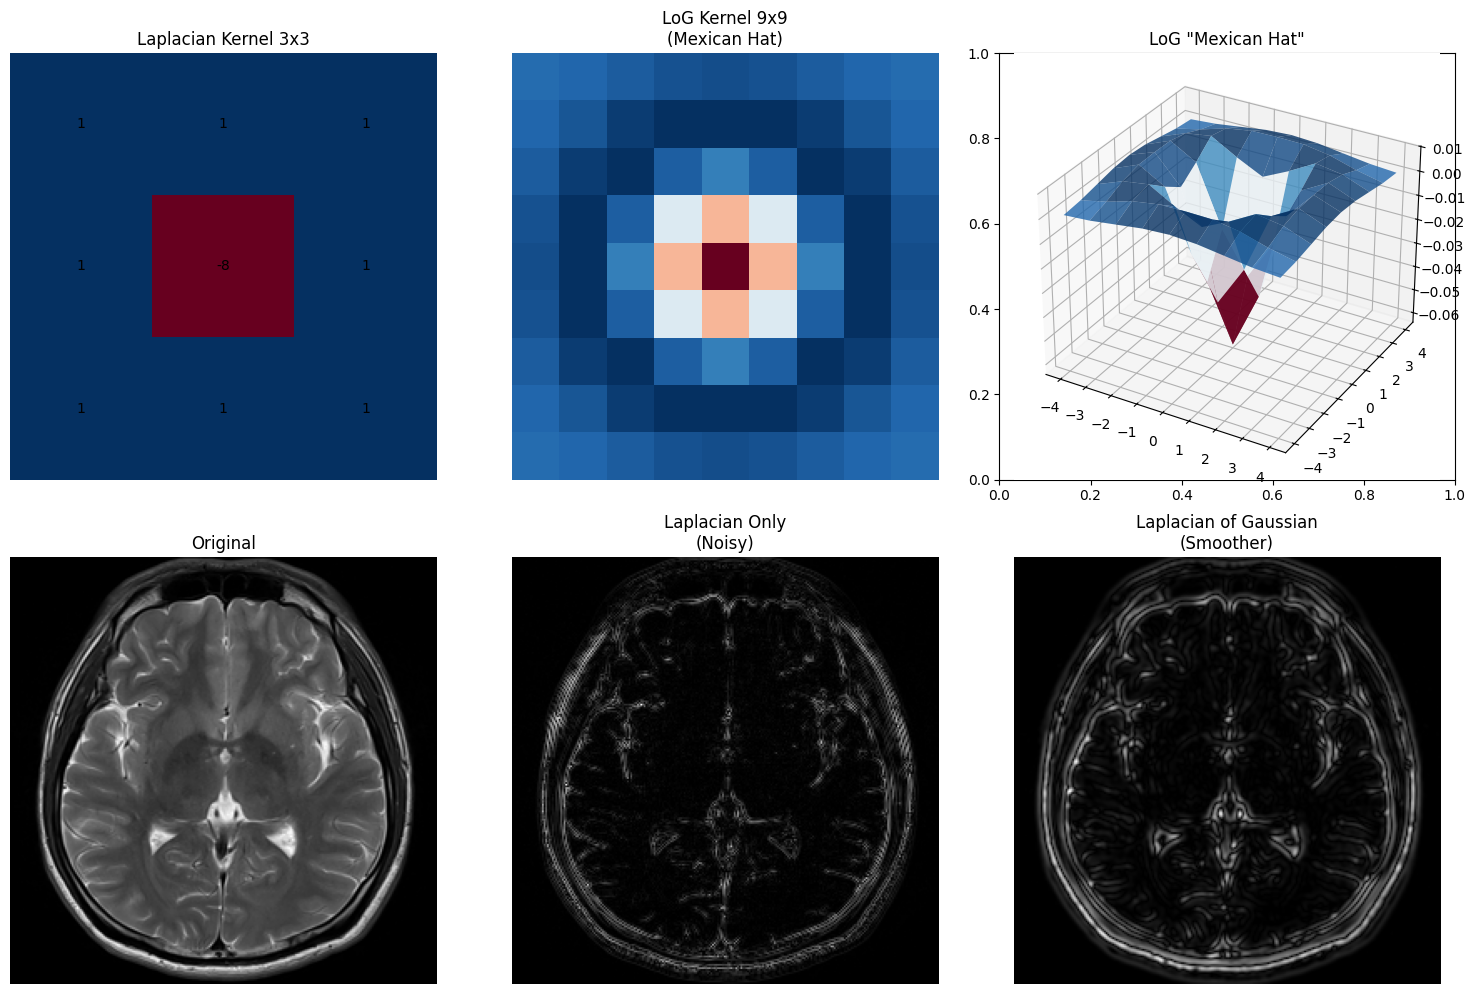

In [8]:
def gaussian_kernel(size, sigma):
    """Create Gaussian kernel."""
    x = np.arange(size) - size // 2
    kernel_1d = np.exp(-x**2 / (2 * sigma**2))
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d / kernel_2d.sum()

def log_kernel(size, sigma):
    """Create Laplacian of Gaussian kernel."""
    x = np.arange(size) - size // 2
    x, y = np.meshgrid(x, x)
    
    # LoG formula
    r2 = x**2 + y**2
    kernel = -(1 / (np.pi * sigma**4)) * (1 - r2 / (2 * sigma**2)) * np.exp(-r2 / (2 * sigma**2))
    
    # Normalize
    kernel = kernel - kernel.mean()
    return kernel

# Create LoG kernel
log_k = log_kernel(9, 1.5)

# Apply
log_result = convolve2d(medical_img, log_k)

# Compare with plain Laplacian
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Show kernels
axes[0, 0].imshow(laplacian_8, cmap='RdBu')
axes[0, 0].set_title('Laplacian Kernel 3x3')
for i in range(3):
    for j in range(3):
        axes[0, 0].text(j, i, f'{laplacian_8[i,j]:.0f}', ha='center', va='center', fontsize=10)
axes[0, 0].axis('off')

axes[0, 1].imshow(log_k, cmap='RdBu')
axes[0, 1].set_title('LoG Kernel 9x9\n(Mexican Hat)')
axes[0, 1].axis('off')

# 3D view of LoG
ax3d = fig.add_subplot(2, 3, 3, projection='3d')
x = np.arange(9) - 4
X, Y = np.meshgrid(x, x)
ax3d.plot_surface(X, Y, log_k, cmap='RdBu', alpha=0.8)
ax3d.set_title('LoG "Mexican Hat"')

# Results
axes[1, 0].imshow(medical_img, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.abs(lap_8), cmap='gray')
axes[1, 1].set_title('Laplacian Only\n(Noisy)')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.abs(log_result), cmap='gray')
axes[1, 2].set_title('Laplacian of Gaussian\n(Smoother)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 7. Canny Edge Detector

The **Canny edge detector** is considered the optimal edge detector:

1. **Gaussian smoothing** - Reduce noise
2. **Gradient computation** - Find edge strength and direction
3. **Non-maximum suppression** - Thin edges to single pixels
4. **Double thresholding** - Separate strong and weak edges
5. **Edge tracking by hysteresis** - Connect weak edges to strong ones

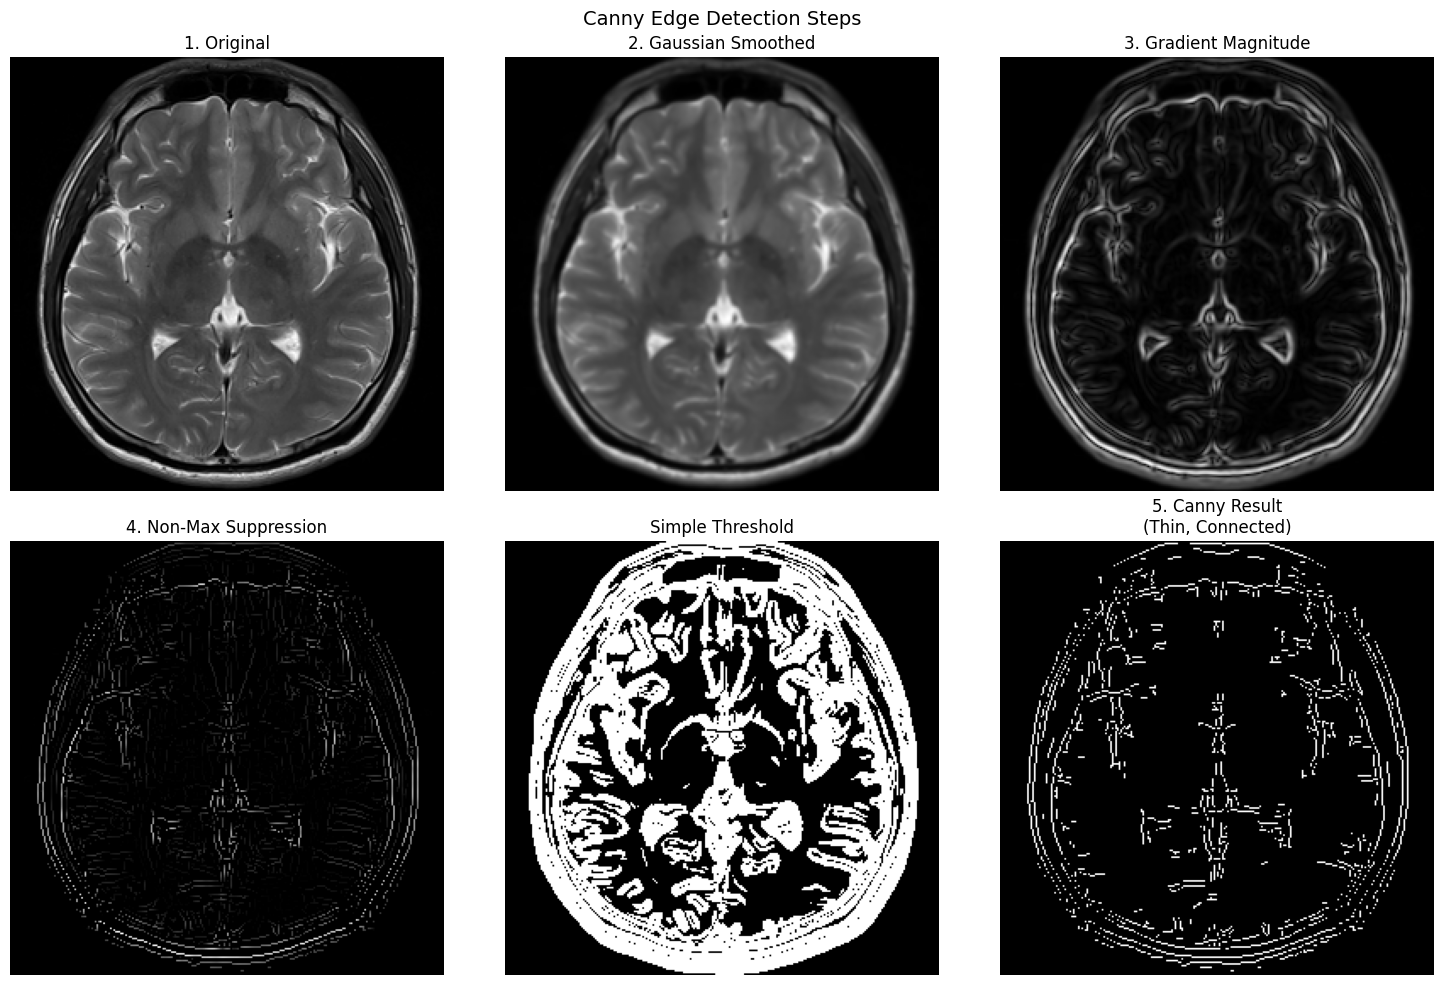

In [9]:
def canny_edge_detector(img, low_threshold=50, high_threshold=100, sigma=1.0):
    """Simplified Canny edge detector."""
    
    # Step 1: Gaussian smoothing
    gaussian = gaussian_kernel(5, sigma)
    smoothed = convolve2d(img, gaussian)
    
    # Step 2: Compute gradients using Sobel
    gx = convolve2d(smoothed, sobel_x)
    gy = convolve2d(smoothed, sobel_y)
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.arctan2(gy, gx) * 180 / np.pi
    direction[direction < 0] += 180
    
    # Step 3: Non-maximum suppression
    h, w = img.shape
    suppressed = np.zeros((h, w))
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            angle = direction[i, j]
            
            # Check neighbors along gradient direction
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                neighbors = [magnitude[i, j-1], magnitude[i, j+1]]
            elif 22.5 <= angle < 67.5:
                neighbors = [magnitude[i-1, j+1], magnitude[i+1, j-1]]
            elif 67.5 <= angle < 112.5:
                neighbors = [magnitude[i-1, j], magnitude[i+1, j]]
            else:
                neighbors = [magnitude[i-1, j-1], magnitude[i+1, j+1]]
            
            if magnitude[i, j] >= max(neighbors):
                suppressed[i, j] = magnitude[i, j]
    
    # Step 4: Double thresholding
    strong = suppressed > high_threshold
    weak = (suppressed >= low_threshold) & (suppressed <= high_threshold)
    
    # Step 5: Edge tracking by hysteresis (simplified)
    edges = np.zeros((h, w), dtype=np.uint8)
    edges[strong] = 255
    
    # Connect weak edges to strong edges
    for i in range(1, h-1):
        for j in range(1, w-1):
            if weak[i, j]:
                # Check if connected to strong edge
                if np.any(strong[i-1:i+2, j-1:j+2]):
                    edges[i, j] = 255
    
    return edges, smoothed, magnitude, suppressed

# Apply Canny
edges, smoothed, magnitude, suppressed = canny_edge_detector(medical_img, low_threshold=30, high_threshold=80)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(medical_img, cmap='gray')
axes[0, 0].set_title('1. Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(smoothed, cmap='gray')
axes[0, 1].set_title('2. Gaussian Smoothed')
axes[0, 1].axis('off')

axes[0, 2].imshow(magnitude, cmap='gray')
axes[0, 2].set_title('3. Gradient Magnitude')
axes[0, 2].axis('off')

axes[1, 0].imshow(suppressed, cmap='gray')
axes[1, 0].set_title('4. Non-Max Suppression')
axes[1, 0].axis('off')

axes[1, 1].imshow(magnitude > 30, cmap='gray')
axes[1, 1].set_title('Simple Threshold')
axes[1, 1].axis('off')

axes[1, 2].imshow(edges, cmap='gray')
axes[1, 2].set_title('5. Canny Result\n(Thin, Connected)')
axes[1, 2].axis('off')

plt.suptitle('Canny Edge Detection Steps', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Threshold Selection

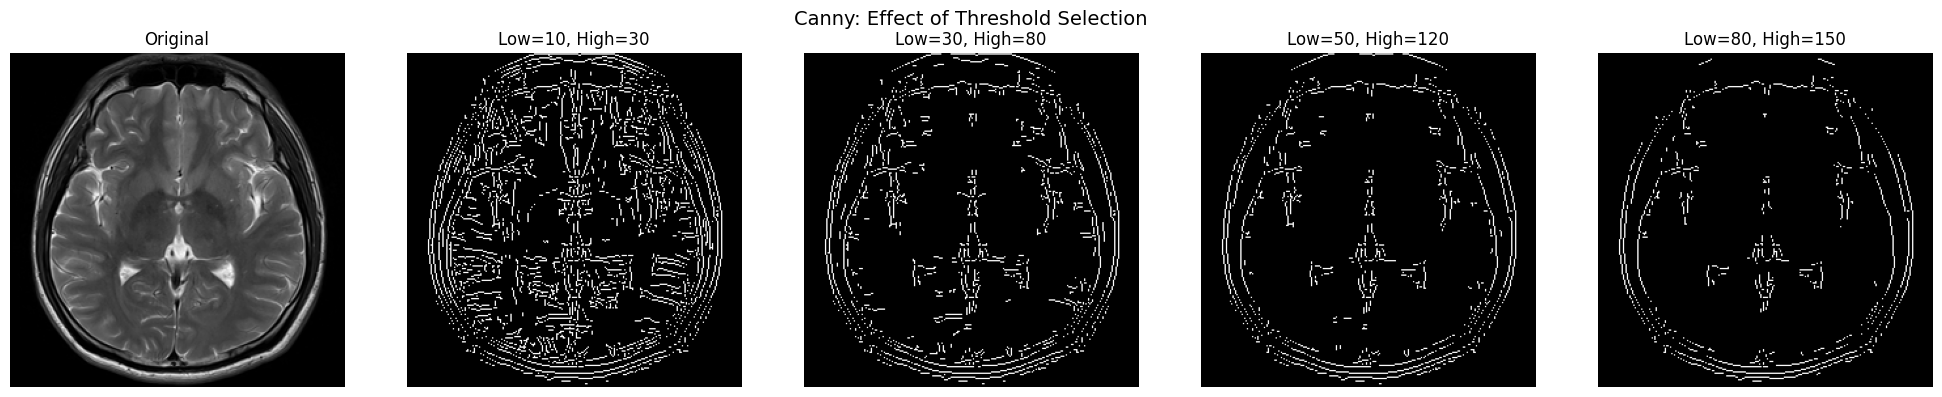

Low thresholds = More edges (including noise)
High thresholds = Only strong edges


In [10]:
# Compare different threshold settings
thresholds = [(10, 30), (30, 80), (50, 120), (80, 150)]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

axes[0].imshow(medical_img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

for i, (low, high) in enumerate(thresholds):
    edges, _, _, _ = canny_edge_detector(medical_img, low_threshold=low, high_threshold=high)
    axes[i+1].imshow(edges, cmap='gray')
    axes[i+1].set_title(f'Low={low}, High={high}')
    axes[i+1].axis('off')

plt.suptitle('Canny: Effect of Threshold Selection', fontsize=14)
plt.tight_layout()
plt.show()

print("Low thresholds = More edges (including noise)")
print("High thresholds = Only strong edges")

## 9. Medical Imaging Application: Organ Boundary Detection

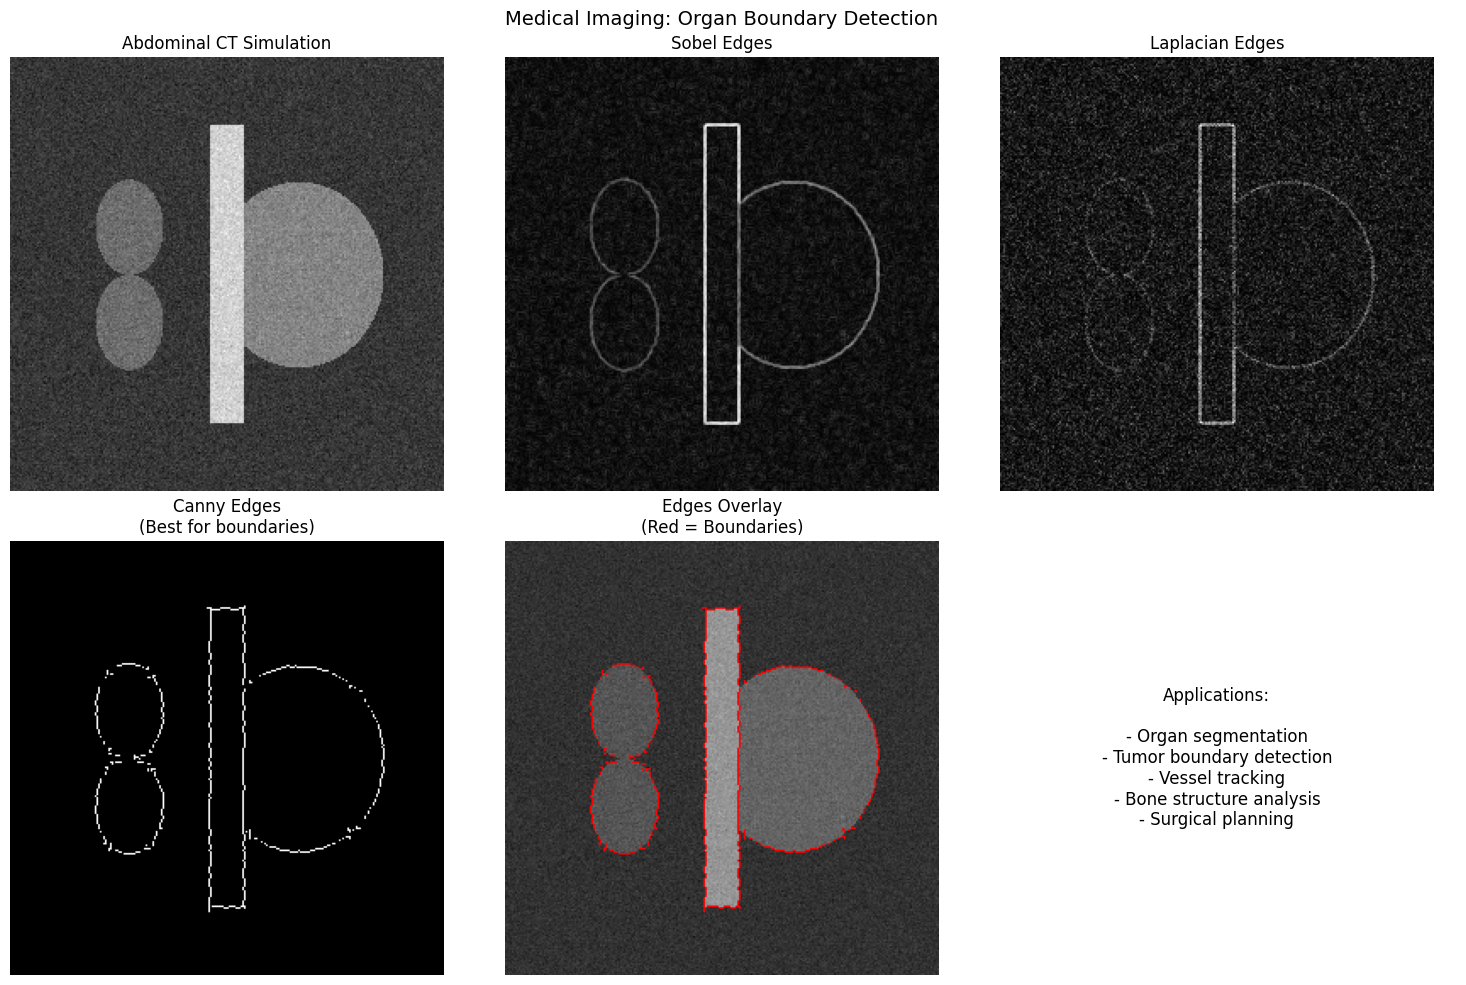

In [11]:
# Create a more detailed medical image
np.random.seed(42)
organ_img = np.ones((256, 256)) * 50

# Add organs with smooth boundaries
y, x = np.ogrid[:256, :256]

# Liver-like structure
liver = ((x - 170)**2/2500 + (y - 128)**2/3000) < 1
organ_img[liver] = 100

# Kidney-like structures
kidney1 = ((x - 70)**2/400 + (y - 100)**2/800) < 1
kidney2 = ((x - 70)**2/400 + (y - 156)**2/800) < 1
organ_img[kidney1] = 85
organ_img[kidney2] = 85

# Spine
organ_img[40:216, 118:138] = 150

# Add realistic noise
organ_img = organ_img + np.random.normal(0, 8, organ_img.shape)
organ_img = np.clip(organ_img, 0, 255).astype(np.uint8)

# Apply different edge detectors
sobel_edges = np.sqrt(convolve2d(organ_img, sobel_x)**2 + convolve2d(organ_img, sobel_y)**2)
lap_edges = np.abs(convolve2d(organ_img, laplacian_8))
canny_edges, _, _, _ = canny_edge_detector(organ_img, low_threshold=20, high_threshold=60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(organ_img, cmap='gray')
axes[0, 0].set_title('Abdominal CT Simulation')
axes[0, 0].axis('off')

axes[0, 1].imshow(sobel_edges, cmap='gray')
axes[0, 1].set_title('Sobel Edges')
axes[0, 1].axis('off')

axes[0, 2].imshow(lap_edges, cmap='gray')
axes[0, 2].set_title('Laplacian Edges')
axes[0, 2].axis('off')

axes[1, 0].imshow(canny_edges, cmap='gray')
axes[1, 0].set_title('Canny Edges\n(Best for boundaries)')
axes[1, 0].axis('off')

# Overlay edges on original
overlay = np.stack([organ_img, organ_img, organ_img], axis=-1)
overlay[canny_edges > 0] = [255, 0, 0]  # Red edges
axes[1, 1].imshow(overlay)
axes[1, 1].set_title('Edges Overlay\n(Red = Boundaries)')
axes[1, 1].axis('off')

axes[1, 2].axis('off')
axes[1, 2].text(0.5, 0.5, 'Applications:\n\n- Organ segmentation\n- Tumor boundary detection\n- Vessel tracking\n- Bone structure analysis\n- Surgical planning',
                ha='center', va='center', fontsize=12, transform=axes[1, 2].transAxes)

plt.suptitle('Medical Imaging: Organ Boundary Detection', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Edge Direction and Orientation

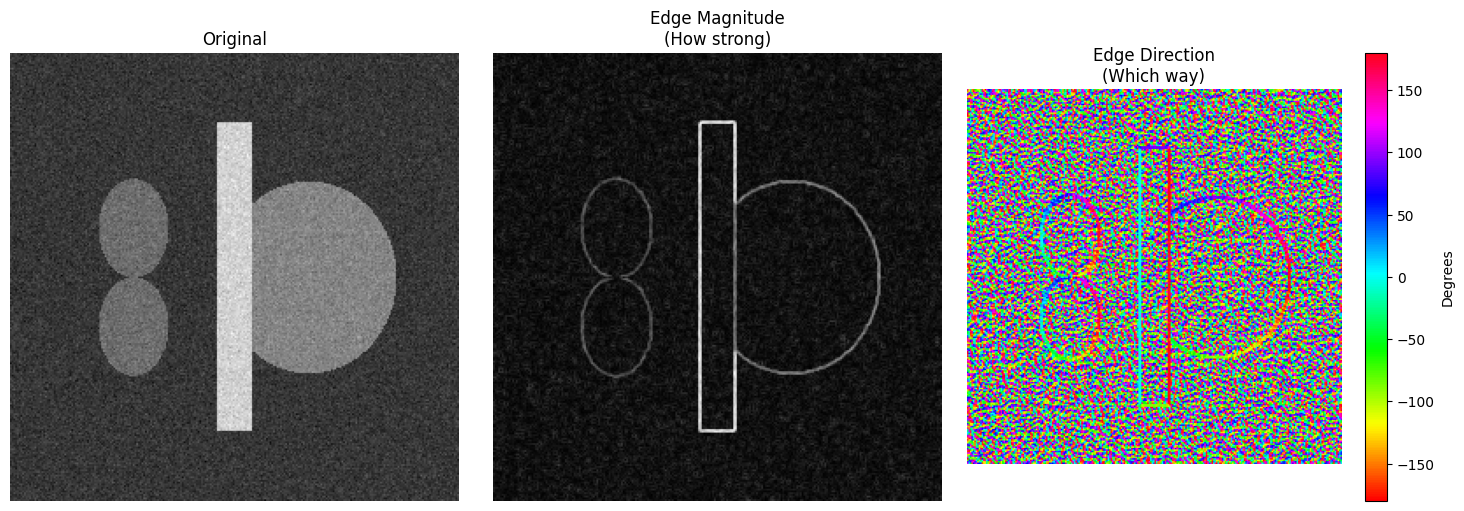

Direction encodes edge orientation:
  0 degrees = Vertical edge (horizontal gradient)
 90 degrees = Horizontal edge (vertical gradient)


In [12]:
# Visualize edge direction
gx = convolve2d(organ_img, sobel_x)
gy = convolve2d(organ_img, sobel_y)
magnitude = np.sqrt(gx**2 + gy**2)
direction = np.arctan2(gy, gx) * 180 / np.pi

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(organ_img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(magnitude, cmap='gray')
axes[1].set_title('Edge Magnitude\n(How strong)')
axes[1].axis('off')

im = axes[2].imshow(direction, cmap='hsv', vmin=-180, vmax=180)
axes[2].set_title('Edge Direction\n(Which way)')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], label='Degrees')

plt.tight_layout()
plt.show()

print("Direction encodes edge orientation:")
print("  0 degrees = Vertical edge (horizontal gradient)")
print(" 90 degrees = Horizontal edge (vertical gradient)")

## 11. Comparison of All Methods

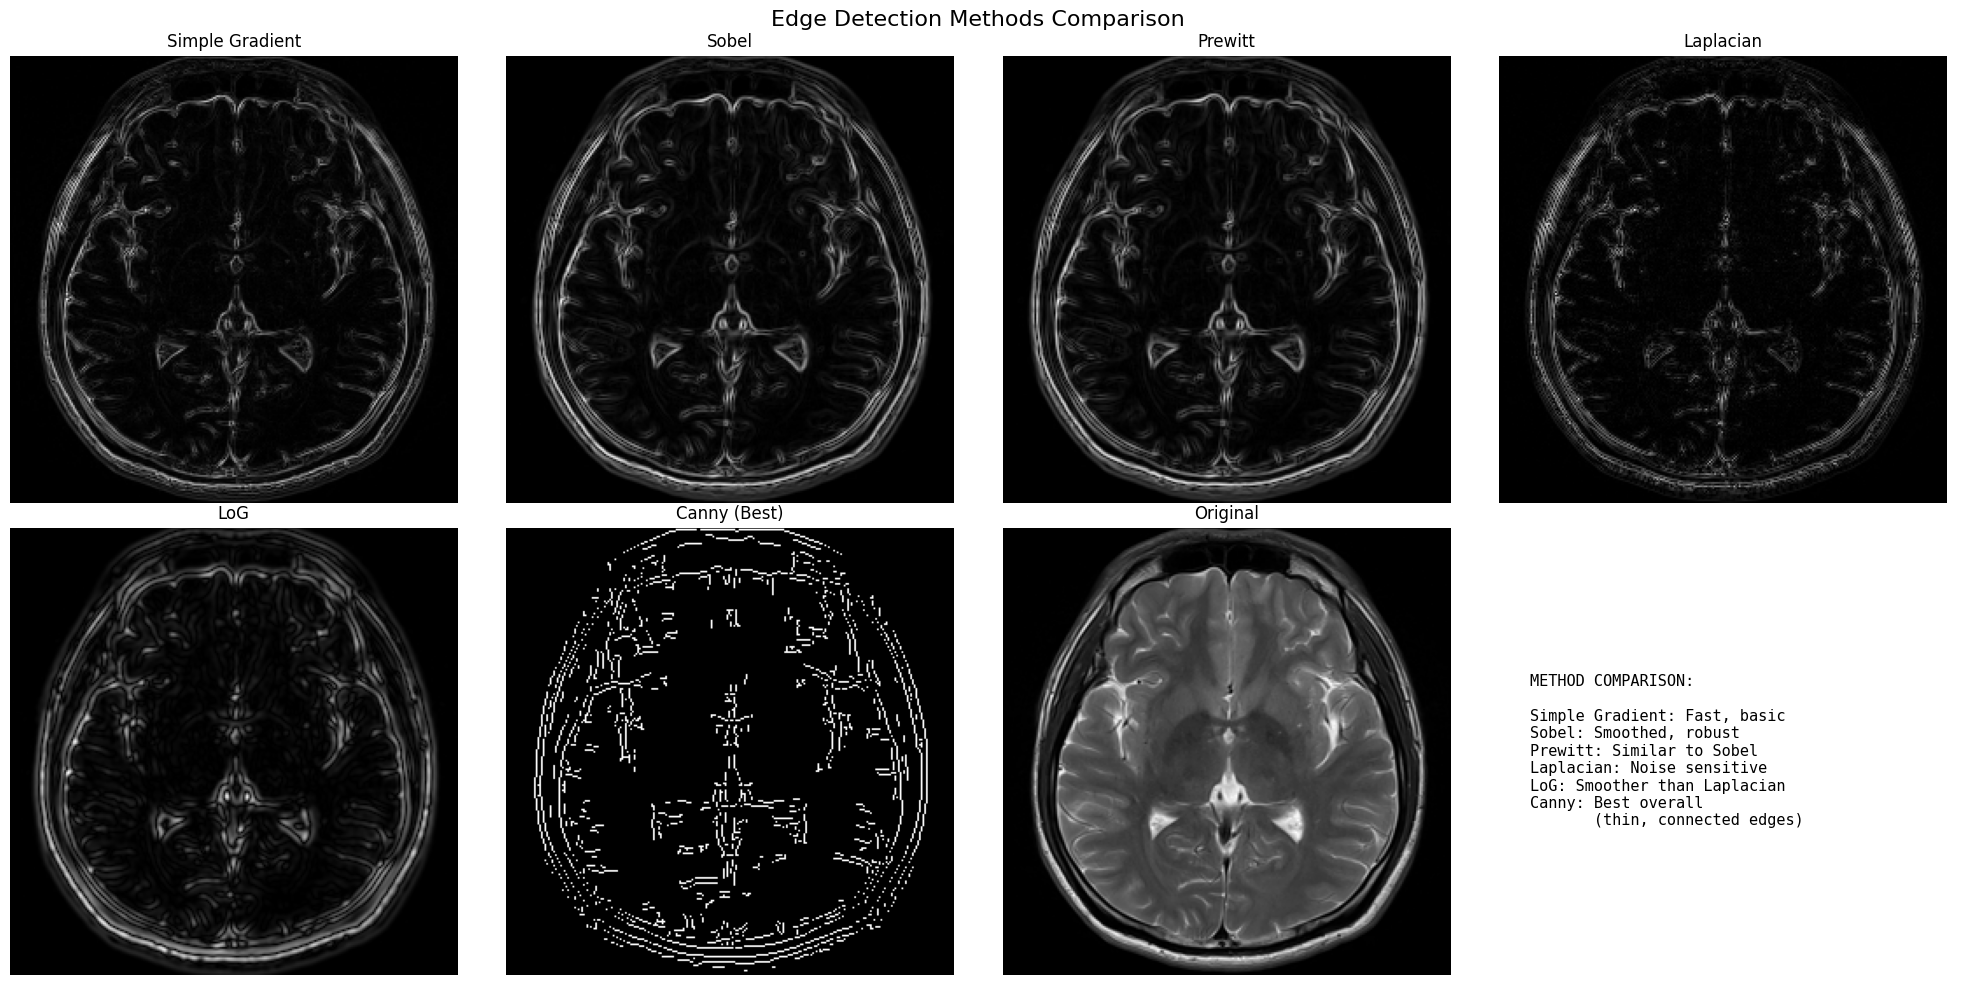

In [13]:
# Create comparison chart
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Kernels/Methods
methods = [
    ('Simple Gradient', simple_gradient(medical_img)[2]),
    ('Sobel', sobel_magnitude),
    ('Prewitt', prewitt_magnitude),
    ('Laplacian', np.abs(lap_8)),
]

for i, (name, result) in enumerate(methods):
    axes[0, i].imshow(result, cmap='gray')
    axes[0, i].set_title(name)
    axes[0, i].axis('off')

# Row 2: LoG, Canny, and summary
axes[1, 0].imshow(np.abs(log_result), cmap='gray')
axes[1, 0].set_title('LoG')
axes[1, 0].axis('off')

canny_final, _, _, _ = canny_edge_detector(medical_img, 25, 70)
axes[1, 1].imshow(canny_final, cmap='gray')
axes[1, 1].set_title('Canny (Best)')
axes[1, 1].axis('off')

# Original for reference
axes[1, 2].imshow(medical_img, cmap='gray')
axes[1, 2].set_title('Original')
axes[1, 2].axis('off')

# Summary
axes[1, 3].axis('off')
summary = """
METHOD COMPARISON:

Simple Gradient: Fast, basic
Sobel: Smoothed, robust
Prewitt: Similar to Sobel
Laplacian: Noise sensitive
LoG: Smoother than Laplacian
Canny: Best overall
       (thin, connected edges)
"""
axes[1, 3].text(0.1, 0.5, summary, fontsize=11, family='monospace',
                verticalalignment='center', transform=axes[1, 3].transAxes)

plt.suptitle('Edge Detection Methods Comparison', fontsize=16)
plt.tight_layout()
plt.show()

## 12. Summary

In [14]:
print("""
SUMMARY: EDGE DETECTION
========================

1. WHAT IS AN EDGE?
   - Rapid change in intensity
   - Detected by computing derivatives (gradients)

2. GRADIENT-BASED METHODS (1st Derivative):
   - Sobel: 3x3 kernel, weighted center
   - Prewitt: 3x3 kernel, uniform weights
   - Compute Gx and Gy, then magnitude = sqrt(Gx^2 + Gy^2)

3. LAPLACIAN (2nd Derivative):
   - Detects zero-crossings
   - More sensitive to noise
   - LoG (Laplacian of Gaussian) reduces noise

4. CANNY EDGE DETECTOR (Optimal):
   Step 1: Gaussian smoothing
   Step 2: Gradient computation
   Step 3: Non-maximum suppression
   Step 4: Double thresholding
   Step 5: Edge tracking by hysteresis

5. KEY PARAMETERS:
   - Threshold: Higher = fewer edges
   - Kernel size: Larger = more smoothing
   - Sigma (Gaussian): Larger = more blur

6. MEDICAL APPLICATIONS:
   - Organ boundary detection
   - Tumor margin identification
   - Vessel segmentation
   - Bone structure analysis

For most applications, Canny is the best choice!
""")


SUMMARY: EDGE DETECTION

1. WHAT IS AN EDGE?
   - Rapid change in intensity
   - Detected by computing derivatives (gradients)

2. GRADIENT-BASED METHODS (1st Derivative):
   - Sobel: 3x3 kernel, weighted center
   - Prewitt: 3x3 kernel, uniform weights
   - Compute Gx and Gy, then magnitude = sqrt(Gx^2 + Gy^2)

3. LAPLACIAN (2nd Derivative):
   - Detects zero-crossings
   - More sensitive to noise
   - LoG (Laplacian of Gaussian) reduces noise

4. CANNY EDGE DETECTOR (Optimal):
   Step 1: Gaussian smoothing
   Step 2: Gradient computation
   Step 3: Non-maximum suppression
   Step 4: Double thresholding
   Step 5: Edge tracking by hysteresis

5. KEY PARAMETERS:
   - Threshold: Higher = fewer edges
   - Kernel size: Larger = more smoothing
   - Sigma (Gaussian): Larger = more blur

6. MEDICAL APPLICATIONS:
   - Organ boundary detection
   - Tumor margin identification
   - Vessel segmentation
   - Bone structure analysis

For most applications, Canny is the best choice!

